### Data Strategy

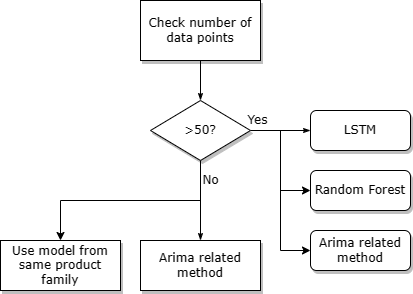

### Model Strategy


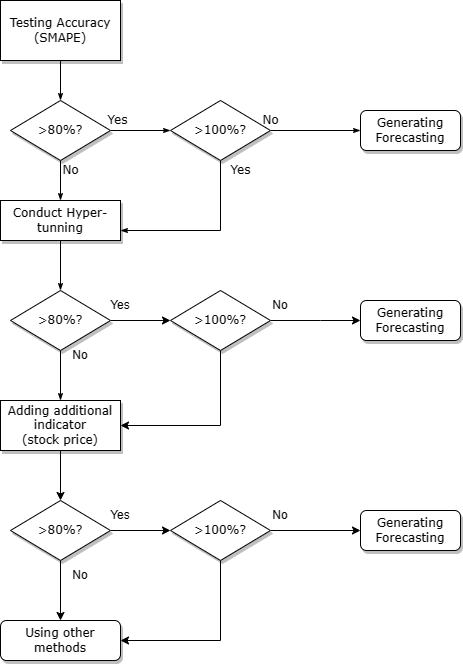


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
# loss function of smape
def smape_loss(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    numerator = tf.reduce_sum(tf.abs(y_true - y_pred))
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / denominator

# Function to create lag window
def slicewindow(data, step):
    X, y = [], []
    for i in range(0, len(data) - step, 1):
        end = i + step
        oneX, oney = data[i:end, :], data[end, :]
        X.append(oneX)
        y.append(oney)
    return np.array(X), np.array(y)

# function to create training and testing datasets
def datasplit(dataset, step):
    datasetX, datasetY = slicewindow(dataset, step)
    train_size = int(len(datasetX) * 0.80)
    X_train, y_train = datasetX[0:train_size, :], datasetY[0:train_size, :]
    X_test, y_test = datasetX[train_size:len(datasetX), :], datasetY[train_size:len(datasetX), :]
    X_train = X_train.reshape(X_train.shape[0], step, -1)
    X_test = X_test.reshape(X_test.shape[0], step, -1)
    return X_train, X_test, y_train, y_test

# function of LSTM model
def seq2seqModel(X, step):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(step, X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(X.shape[2]))
    model.compile(optimizer='adam', loss=smape_loss)
    return model

# function to create future demand
def predictfuture(dataset, step, model, period):
    for _ in range(period):
        datasetX = dataset[-step:]
        X_train = datasetX.reshape(1, step, datasetX.shape[1])
        next_prediction = model.predict(X_train)
        dataset = np.vstack([dataset, next_prediction])
    return dataset[-period:]

# Plot the trend
def plotting(result):
    actual = pd.DataFrame(result[4].reset_index(drop=True))
    predict = pd.DataFrame(result[3])
    predict.index = list(range(len(actual) - 8, len(actual)))
    future = pd.DataFrame(result[2])
    future.index = list(range(len(actual), len(actual) + 6))
    plt.figure(figsize=(12, 6))
    plt.plot(actual['demand'], label="Actual Demand")
    plt.plot(predict[0], label="Predicted Demand")
    plt.plot(future[0], label="Future Demand")
    plt.xlabel("Months")
    plt.ylabel("Demand")
    plt.title("Actual vs Predicted Demand: %s" % name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    kurs = "%s.png" % name
    plt.savefig(kurs, format='png')
    plt.show()

In [24]:
# Load the Excel file
df_origin = pd.read_csv('20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv')

#delete discontinuing products
df_continue = df_origin[df_origin['reporting_time']=='2023-02-01T00:00:00.000Z']
df_continue_origin = df_origin[df_origin['product_name'].isin(df_continue['product_name'])]

# Check number of datapoints
product_counts = df_continue_origin['product_name'].value_counts()
i=0
for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if product_counts[name] > 50:
        i=i+1
print(i)

100%|██████████| 1392/1392 [00:00<00:00, 232636.22it/s]

1024


  0%|          | 0/1920 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 20ms/step


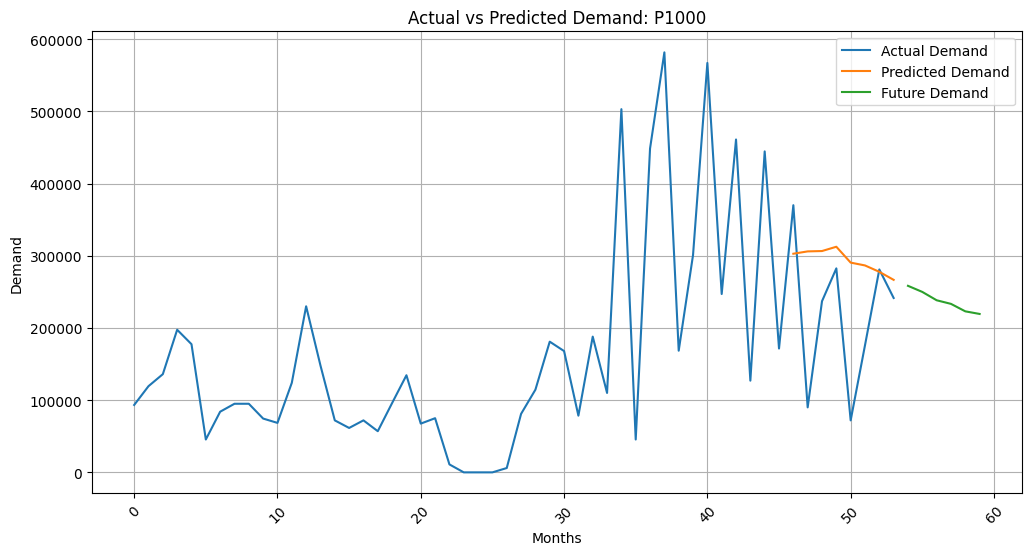

  0%|          | 4/1920 [00:05<46:11,  1.45s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 21: early stopping
1/1 [==============================] - 0s 382ms/step


  0%|          | 5/1920 [00:11<1:21:26,  2.55s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 14ms/step


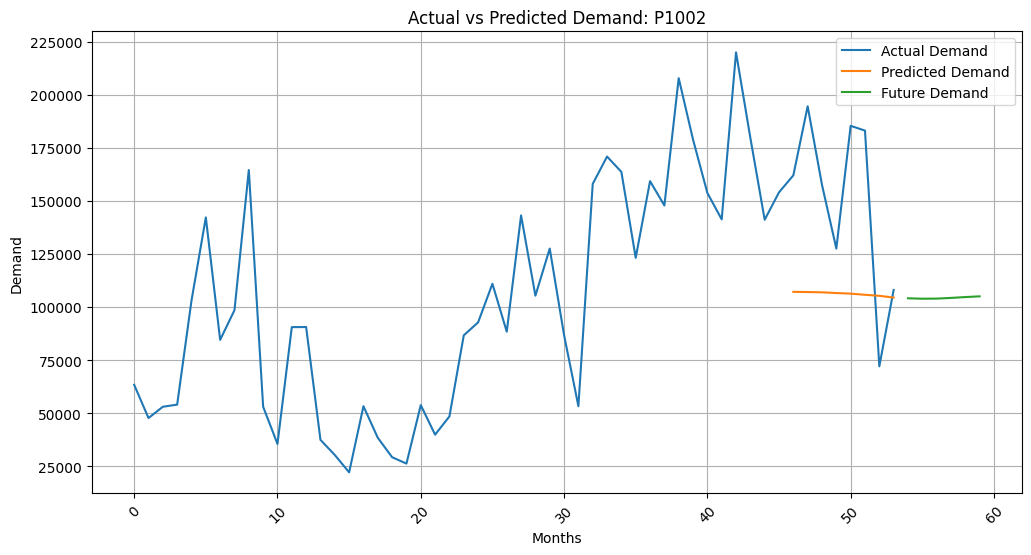

  0%|          | 6/1920 [00:20<2:22:09,  4.46s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 387ms/step


  0%|          | 7/1920 [00:27<2:42:23,  5.09s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 16: early stopping
1/1 [==============================] - 0s 500ms/step


  0%|          | 8/1920 [00:34<2:59:57,  5.65s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 32: early stopping
1/1 [==============================] - 0s 233ms/step


  0%|          | 9/1920 [00:39<2:54:46,  5.49s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 24: early stopping
1/1 [==============================] - 0s 232ms/step


  1%|          | 10/1920 [00:43<2:37:26,  4.95s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 10: early stopping
1/1 [==============================] - 0s 294ms/step


  1%|          | 11/1920 [00:47<2:30:38,  4.73s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 301ms/step


  1%|          | 12/1920 [00:52<2:32:27,  4.79s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 24: early stopping
1/1 [==============================] - 0s 377ms/step


  1%|          | 13/1920 [00:58<2:43:54,  5.16s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 461ms/step


  1%|          | 15/1920 [01:06<2:28:13,  4.67s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 16ms/step


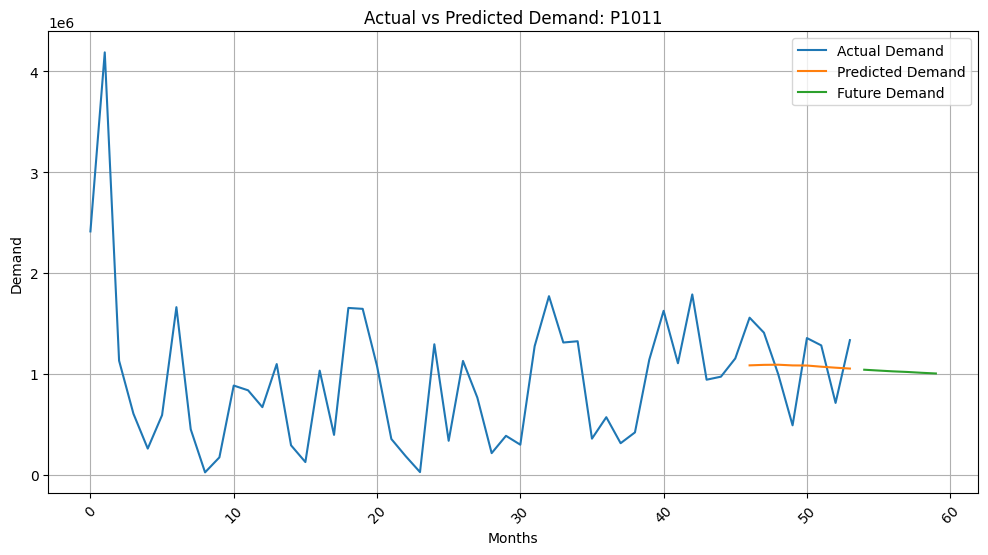

  1%|          | 16/1920 [01:15<3:01:53,  5.73s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 316ms/step


  1%|          | 17/1920 [01:24<3:25:12,  6.47s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 38ms/step


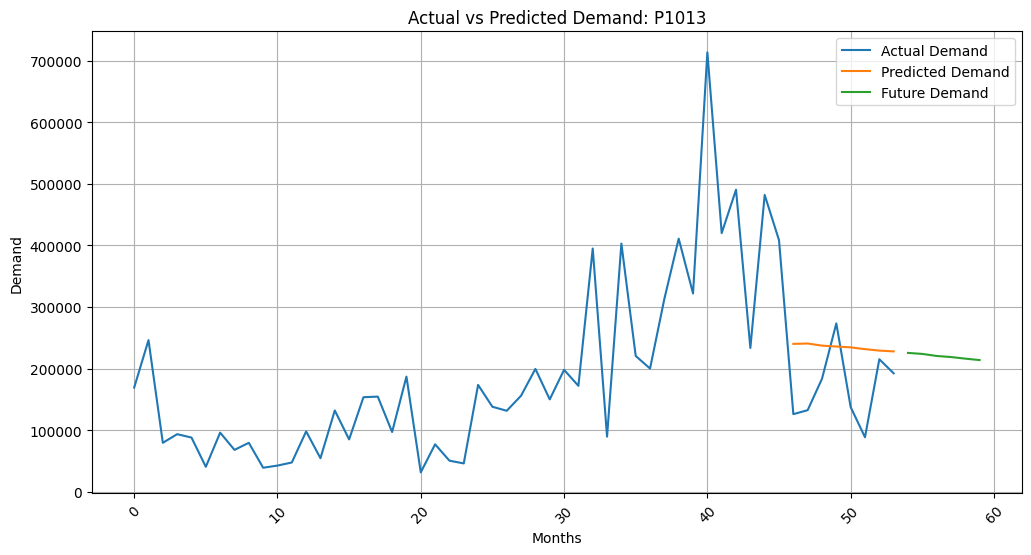

  1%|          | 18/1920 [01:30<3:18:52,  6.27s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 29: early stopping
1/1 [==============================] - 0s 316ms/step


  1%|          | 19/1920 [01:35<3:14:04,  6.13s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 270ms/step


  1%|          | 20/1920 [01:41<3:06:00,  5.87s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 254ms/step


  1%|          | 21/1920 [01:45<2:54:31,  5.51s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 50: early stopping
1/1 [==============================] - 0s 300ms/step


  1%|          | 22/1920 [01:50<2:46:43,  5.27s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 25: early stopping
1/1 [==============================] - 0s 238ms/step


  1%|          | 23/1920 [01:54<2:34:53,  4.90s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 236ms/step


  1%|▏         | 24/1920 [01:59<2:32:56,  4.84s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 232ms/step


  1%|▏         | 26/1920 [02:03<1:54:32,  3.63s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 273ms/step


  1%|▏         | 27/1920 [02:08<2:07:08,  4.03s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 223ms/step


  1%|▏         | 28/1920 [02:13<2:10:20,  4.13s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 238ms/step


  2%|▏         | 29/1920 [02:17<2:12:26,  4.20s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 18: early stopping
1/1 [==============================] - 0s 301ms/step


  2%|▏         | 30/1920 [02:21<2:09:21,  4.11s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 232ms/step


  2%|▏         | 31/1920 [02:27<2:23:52,  4.57s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 21: early stopping
1/1 [==============================] - 0s 216ms/step


  2%|▏         | 32/1920 [02:30<2:13:13,  4.23s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 22: early stopping
1/1 [==============================] - 0s 232ms/step


  2%|▏         | 33/1920 [02:33<2:05:34,  3.99s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 470ms/step


  2%|▏         | 34/1920 [02:40<2:26:24,  4.66s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 31ms/step


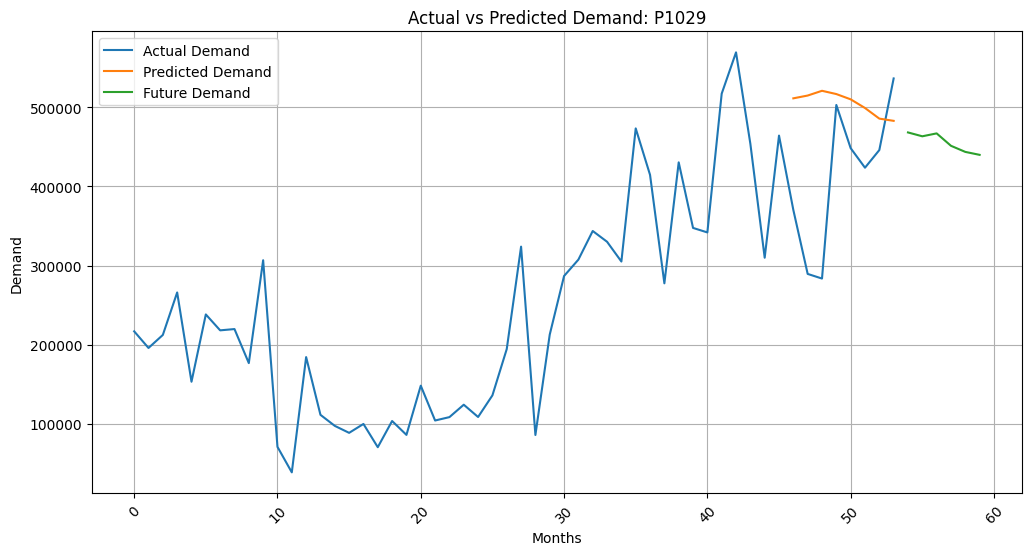

  2%|▏         | 35/1920 [02:45<2:36:13,  4.97s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 231ms/step


  2%|▏         | 37/1920 [02:50<1:56:24,  3.71s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 48: early stopping
1/1 [==============================] - 0s 463ms/step


  2%|▏         | 38/1920 [02:56<2:12:43,  4.23s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 332ms/step


  2%|▏         | 39/1920 [03:03<2:34:48,  4.94s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 232ms/step


  2%|▏         | 41/1920 [03:07<2:00:48,  3.86s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 263ms/step


  2%|▏         | 43/1920 [03:13<1:45:57,  3.39s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 21: early stopping
1/1 [==============================] - 0s 225ms/step


  2%|▏         | 44/1920 [03:16<1:46:06,  3.39s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 11: early stopping
1/1 [==============================] - 0s 216ms/step


  2%|▏         | 45/1920 [03:19<1:43:28,  3.31s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 285ms/step


  2%|▏         | 46/1920 [03:24<1:56:05,  3.72s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 247ms/step


  2%|▎         | 48/1920 [03:30<1:48:27,  3.48s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 238ms/step


  3%|▎         | 50/1920 [03:35<1:33:47,  3.01s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 254ms/step


  3%|▎         | 53/1920 [03:39<1:12:30,  2.33s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 21: early stopping
1/1 [==============================] - 0s 454ms/step


  3%|▎         | 54/1920 [03:45<1:28:30,  2.85s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 13: early stopping
1/1 [==============================] - 0s 232ms/step


  3%|▎         | 55/1920 [03:49<1:36:29,  3.10s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 223ms/step


  3%|▎         | 59/1920 [03:53<1:03:18,  2.04s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 26: early stopping
1/1 [==============================] - 0s 338ms/step


  3%|▎         | 63/1920 [03:57<48:34,  1.57s/it]  C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 36: early stopping
1/1 [==============================] - 0s 238ms/step


  3%|▎         | 64/1920 [04:03<1:07:18,  2.18s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 232ms/step


  4%|▍         | 73/1920 [04:07<34:10,  1.11s/it]  C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 20: early stopping
1/1 [==============================] - 0s 232ms/step


  6%|▌         | 115/1920 [04:11<08:36,  3.50it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 17: early stopping
1/1 [==============================] - 0s 300ms/step


  6%|▌         | 119/1920 [04:15<10:41,  2.81it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 238ms/step


  6%|▋         | 120/1920 [04:20<15:09,  1.98it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 14: early stopping
1/1 [==============================] - 0s 238ms/step


  6%|▋         | 121/1920 [04:23<18:55,  1.58it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 38: early stopping
1/1 [==============================] - 0s 238ms/step


  6%|▋         | 122/1920 [04:27<25:24,  1.18it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 0s 247ms/step


  6%|▋         | 123/1920 [04:34<40:22,  1.35s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 12: early stopping
1/1 [==============================] - 0s 330ms/step


  6%|▋         | 124/1920 [04:38<46:38,  1.56s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 10: early stopping
1/1 [==============================] - 0s 336ms/step


  7%|▋         | 126/1920 [04:42<52:45,  1.76s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 19: early stopping
1/1 [==============================] - 0s 362ms/step


  7%|▋         | 127/1920 [04:48<1:07:42,  2.27s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 6: early stopping
1/1 [==============================] - 0s 350ms/step


  7%|▋         | 128/1920 [04:53<1:19:59,  2.68s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 17: early stopping
1/1 [==============================] - 0s 416ms/step


  7%|▋         | 130/1920 [04:58<1:22:09,  2.75s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 10: early stopping
1/1 [==============================] - 0s 487ms/step


  7%|▋         | 135/1920 [05:04<57:34,  1.94s/it]  C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


1/1 [==============================] - 1s 617ms/step


  7%|▋         | 137/1920 [05:15<1:19:16,  2.67s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Epoch 8: early stopping
1/1 [==============================] - 1s 770ms/step


  7%|▋         | 141/1920 [05:23<1:11:27,  2.41s/it]C:\Users\user\AppData\Local\Temp\ipykernel_19692\2477932781.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()
  7%|▋         | 142/1920 [05:27<1:08:24,  2.31s/it]


KeyboardInterrupt: 

In [4]:
result = {}
result_less80 = {}
result_other = {}
# Use previous 15 data to predict next demand
step = 15 
future_periods = 6

for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if product_counts[name] > 50:
        df = df_continue_origin.loc[df_continue_origin['product_name'] == name]

        # calculate the correlation between each feature and demand and choose the first 8 features
        corr_matrix = df.corr()
        demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
        index_list = demand_corr.index.tolist()
        df = df[index_list[0:8]]
        
        # Normalize the data
        scaler = StandardScaler()
        df_sc = scaler.fit_transform(df.reset_index(drop=True))
        dataset = np.array(df_sc)
        
        X_train, X_test, y_train, y_test = datasplit(dataset, step)
        model = seq2seqModel(X_train, step)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        model.fit(X_train, y_train, epochs=50, verbose=0, validation_split=0.2, batch_size=64, callbacks=[es])
        y_pred = model.predict(X_test)
        predicted_demand = scaler.inverse_transform(y_pred)
        y_true = scaler.inverse_transform(y_test)
        smape = smape_loss(y_true[:, 0], predicted_demand[:, 0])
        if 0.00 < smape < 1.00:
            accuracy = 1.00 - smape
            if accuracy > 0.79999999:
                future = predictfuture(dataset, step, model, future_periods)
                future_demand = scaler.inverse_transform(future)[:, 0]
                result[name] = [accuracy, smape, future_demand, predicted_demand[:, 0], df['demand'], model]
                plotting(result[name])
            else:
                result_less80[name] = [accuracy, smape, X_train, X_test, y_train, y_test]
        else:
            result_other[name] = [accuracy, smape, X_train, X_test, y_train, y_test]

### Hypertunning (wip)

In [ ]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, activation='relu'))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=x_train.shape[2]))
        regressor.compile(optimizer='adam', loss=smape_loss)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [ ]:
config = [[False], [False], [False], [16, 32, 50, 100], [8, 16, 32], [0.1, 0.2, 0.3]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]
accuracy, smape, X_train, y_train, X_test, y_test = result_less80[name] 
hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)